## 🔧 Code guidelines:
- Please follow python coding convention "e.g. imports are alphabetically sorted".
- Use python type hinting for increased readability of your code.
- Please add any helper functions in the helper functions block.
- It is preferred to implement one-time-local-helper-functions inside your parent function.

## 🦦 Managing virtual environments:
```Console
*** Mac:
$ python3 -m venv venv
$ source venv/bin/activate
$ pip3 install -r requirements.txt
$ pip3 freeze > requirements.txt 
$ deactivate

*** Mac:
$ python -m venv venv
$ venv\Scripts\activate.bat
$ pip install -r requirements.txt
$ pip freeze > requirements.txt 
$ deactivate
```

In [218]:
import cv2
import imutils
import matplotlib.pyplot as plt
import numpy as np
import skimage as sk
import skimage.measure
from typing import Final

In [219]:
# [0]: Add helper functions here
def show_images(images, titles=None):
    """Display a list of images in a single figure with matplotlib."""
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images,titles), start=1):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        plt.axis('off')
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

In [220]:
# [1]: Crop Number Plate
def crop_image(image: np.ndarray) -> np.ndarray:
    # [0]: Local CONSTANTS
    CANNY_THRESH_LOW: Final[int] = 170
    CANNY_THRESH_HIGH: Final[int] = 200
    BILATERAL_FILTER_SIZE: Final[int] = 11
    BILATERAL_FILTER_SIGMA_COLOR: Final[int] = 17
    BILATERAL_FILTER_SIGMA_SPACE: Final[int] = 17
    MAX_NUM_CONTOURS: Final[int] = 30
    # [1]: Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # [2]: Reduce noise and preserve edges
    gray = cv2.bilateralFilter(
        gray, 
        BILATERAL_FILTER_SIZE, 
        BILATERAL_FILTER_SIGMA_COLOR, 
        BILATERAL_FILTER_SIGMA_SPACE
    )
    # [3]: Edge Detection
    edges = cv2.Canny(gray, CANNY_THRESH_LOW, CANNY_THRESH_HIGH)
    # [4]: Find contours && sort by their area
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:MAX_NUM_CONTOURS]
    # [5]: Find contour with 4 corners
    def get_image(contour) -> np.ndarray:
        x, y, w, h = cv2.boundingRect(contour)
        return gray[y:y+h, x:x+w]
    return [
        get_image(c)
        for c in contours 
        if cv2.approxPolyDP(c, 0.01 * cv2.arcLength(c, True), True).shape[0] == 4
    ][0]

In [221]:
# [2]: Skew Rotation Correction
def rotate_image(image: np.ndarray) -> np.ndarray:
    # [0]: Local CONSTANTS
    CANNY_THRESH_LOW: Final[int] = 0
    CANNY_THRESH_HIGH: Final[int] = 100
    # [2]: Edge Detection
    edges = cv2.Canny(image, CANNY_THRESH_LOW, CANNY_THRESH_HIGH)
    # [3]: Hough Transform
    lines = cv2.HoughLines(edges, 1, np.pi/180, 40)
    # [4]: Find most common angle
    angle = np.degrees(max(
        (line[0][1] for line in lines), 
        key=lambda x: list(lines[:,0,1]).count(x)
    ))
    # [5]: Rotate the image
    return sk.transform.rotate(
        image,
        angle+90 if angle<0 else angle-90
    )

In [222]:
# [3]: Character Segmentation
def segment_characters(image: np.ndarray) -> list[np.ndarray]:
    # [0]: Local CONSTANTS  
    MIN_CONTOUR_AREA: Final[int] = 100
    MIN_PIXEL_WIDTH: Final[int] = 2
    MIN_PIXEL_HEIGHT: Final[int] = 8
    # [1]: Find contours
    contours, _ = cv2.findContours(image.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    # [2]: Filter contours
    def get_image(contour) -> np.ndarray:
        x, y, w, h = cv2.boundingRect(contour)
        return image[y:y+h, x:x+w]
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w > MIN_PIXEL_WIDTH and h > MIN_PIXEL_HEIGHT:
            cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 1)
    return [
        get_image(c)
        for c in contours
        if cv2.contourArea(c) > MIN_CONTOUR_AREA
        and w > MIN_PIXEL_WIDTH
        and h > MIN_PIXEL_HEIGHT
    ]

In [223]:
# [4]: Character Recognition

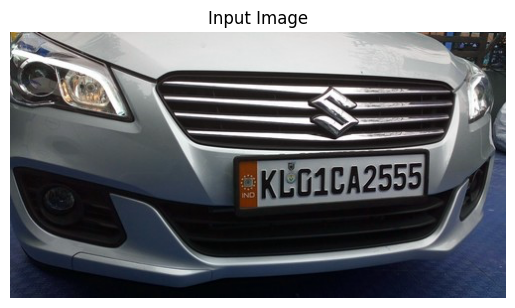

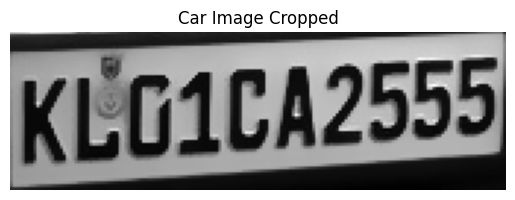

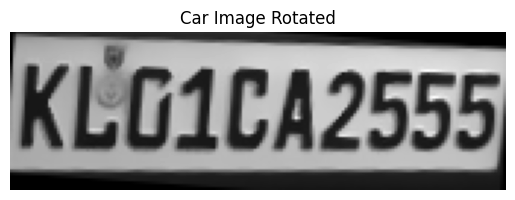

In [224]:
car_image = cv2.imread('./samples/rotation.png')
show_images([car_image], ["Input Image"])
car_image_cropped = crop_image(car_image)
show_images([car_image_cropped], ["Car Image Cropped"])
car_image_rotated = rotate_image(car_image_cropped)
show_images([car_image_rotated], ["Car Image Rotated"])